# Description

It runs a Spectral Clustering (SC) algorithm on the similarity matrix generated by the correlation method specified below (under `Settings`). It saves the set of clustering solutions (called "ensemble") into a pandas dataframe.

# Modules loading

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

from clustermatch import conf
from clustermatch.clustering import generate_ensemble

# Settings

In [2]:
CORRELATION_METHOD_NAME = "spearman"
METHOD_VARIANT = "full"

In [3]:
# we don't have gene subsets for recount2
# GENE_SELECTION_STRATEGY = "var_pc_log2"

In [4]:
# range of k values that will be used by the clustering algorithm
K_RANGE = [2] + np.arange(5, 100 + 1, 5).tolist() + [125, 150, 175, 200]

In [5]:
# number of times the algorithm will be run for each configuration; it will pick the "best" partition among these, according
# to some internal criteria (see the algorithm's documentation for more information on this parameter, which is `n_init`).
N_INIT = 50

In [6]:
INITIAL_RANDOM_STATE = 12345

In [7]:
def process_similarity_matrix(similarity_matrix):
    """
    It process the similarity matrix to perform any needed adjustment before performing cluster analysis on it.
    """
    # see comments for pearson (full) on gtex
    return similarity_matrix + 1.0

In [8]:
def get_distance_matrix(similarity_matrix):
    """
    It converts the processed similarity matrix into a distance matrix. This is needed to compute some clustering quality measures.
    """
    # see comments for pearson (full) on gtex
    return -(similarity_matrix - 1) + 1.0

In [9]:
assert process_similarity_matrix(1) == 2
assert process_similarity_matrix(0) == 1
assert process_similarity_matrix(-1) == 0

In [10]:
assert get_distance_matrix(process_similarity_matrix(1)) == 0
assert get_distance_matrix(process_similarity_matrix(0)) == 1
assert get_distance_matrix(process_similarity_matrix(-1)) == 2

# Paths

In [11]:
INPUT_DIR = conf.RECOUNT2["SIMILARITY_MATRICES_DIR"]
display(INPUT_DIR)
assert INPUT_DIR.exists()

PosixPath('/opt/data/results/recount2/similarity_matrices')

In [12]:
OUTPUT_DIR = conf.RECOUNT2["CLUSTERING_DIR"]
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
display(INPUT_DIR)

PosixPath('/opt/data/results/recount2/similarity_matrices')

# Setup clustering options

In [13]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_RANGE"] = K_RANGE
CLUSTERING_OPTIONS["KMEANS_N_INIT"] = N_INIT

display(CLUSTERING_OPTIONS)

{'K_RANGE': [2,
  5,
  10,
  15,
  20,
  25,
  30,
  35,
  40,
  45,
  50,
  55,
  60,
  65,
  70,
  75,
  80,
  85,
  90,
  95,
  100,
  125,
  150,
  175,
  200],
 'KMEANS_N_INIT': 50}

# Get data files

In [14]:
# get input data files according to Settings
input_files = list(INPUT_DIR.glob(f"*-{CORRELATION_METHOD_NAME}.pkl"))
display(len(input_files))
display(input_files)

assert len(input_files) == 1

1

[PosixPath('/opt/data/results/recount2/similarity_matrices/recount_data_prep_PLIER-spearman.pkl')]

In [15]:
data_file = input_files[0]

## Show the content of one similarity matrix

In [16]:
sim_matrix = pd.read_pickle(data_file)

In [17]:
sim_matrix.shape

(6750, 6750)

In [18]:
sim_matrix.head()

,GAS6,MMP14,DSP,MARCKSL1,SPARC,CTSD,EPAS1,PALLD,PHC2,LGALS3BP,...,LDHB,LDHC,ACAP2,ACAP3,CFL2,CFL1,NFIB,PLEKHG6,GNGT2,SERPINH1
GAS6,1.000000,0.767277,0.530435,0.376058,0.492968,0.652806,0.694218,0.598491,0.599584,0.595290,...,0.096758,0.319135,0.243757,0.669781,0.433053,0.397045,0.298712,0.484416,0.357766,0.689587
MMP14,0.767277,1.000000,0.490369,0.372943,0.593585,0.608753,0.652577,0.566899,0.596954,0.591671,...,0.108111,0.328656,0.295322,0.573781,0.372953,0.388056,0.232660,0.498833,0.371384,0.707476
DSP,0.530435,0.490369,1.000000,0.309156,0.250510,0.378827,0.570500,0.603818,0.261268,0.483510,...,0.102505,0.322113,0.181120,0.336312,0.389993,0.143608,0.396473,0.567024,0.022467,0.615777
MARCKSL1,0.376058,0.372943,0.309156,1.000000,0.251116,0.380241,0.254586,0.286491,0.441862,0.339611,...,0.386577,0.314713,0.302932,0.548047,0.313833,0.454887,0.228858,0.352535,0.312589,0.478413
SPARC,0.492968,0.593585,0.250510,0.251116,1.000000,0.299277,0.404538,0.481395,0.353212,0.426300,...,0.259254,0.219185,0.128572,0.276951,0.441842,0.182518,0.339385,0.180845,0.240672,0.503508


# Clustering

## Generate clusterers

A "clusterer" is an instance of one clustering algorithm with a specified set of parameters. For instance, KMeans with `n_clusters=2` and `random_state=189`.

In [19]:
clusterers = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    clus = SpectralClustering(
        eigen_solver="arpack",
        n_clusters=k,
        n_init=CLUSTERING_OPTIONS["KMEANS_N_INIT"],
        affinity="precomputed",
        random_state=random_state,
    )

    method_name = type(clus).__name__
    clusterers[f"{method_name} #{idx}"] = clus

    random_state = random_state + 1
    idx = idx + 1

In [20]:
display(len(clusterers))

25

In [21]:
_iter = iter(clusterers.items())
display(next(_iter))
display(next(_iter))

('SpectralClustering #0',
 SpectralClustering(affinity='precomputed', eigen_solver='arpack', n_clusters=2,
                    n_init=50, random_state=12345))

('SpectralClustering #1',
 SpectralClustering(affinity='precomputed', eigen_solver='arpack', n_clusters=5,
                    n_init=50, random_state=12346))

In [22]:
clustering_method_name = method_name
display(clustering_method_name)

'SpectralClustering'

## Generate ensemble

In [23]:
# read similarity matrix for this tissue
sim_matrix = pd.read_pickle(data_file)
sim_matrix = process_similarity_matrix(sim_matrix)

In [24]:
# generate ensemble
ensemble = generate_ensemble(
    sim_matrix,
    clusterers,
    tqdm_args={"leave": False, "ncols": 100},
)

In [25]:
# perform some checks on the generate ensemble
# there should be a single k among ensemble partitions
_tmp = ensemble["n_clusters"].value_counts().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == 1

assert not ensemble["n_clusters"].isna().any()

assert ensemble.shape[0] == len(clusterers)

# no partition has negative labels or nan
assert not np.any(
    [np.isnan(part["partition"]).any() for idx, part in ensemble.iterrows()]
)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

# all partitions must have the size of the data
assert np.all(
    [
        part["partition"].shape[0] == sim_matrix.shape[0]
        for idx, part in ensemble.iterrows()
    ]
)

# the number of unique labels in the partition must match the k specified
_real_k_values = ensemble["partition"].apply(lambda x: np.unique(x).shape[0])
assert np.all(ensemble["n_clusters"].values == _real_k_values.values)

In [26]:
# add clustering quality measures
dist_matrix = get_distance_matrix(sim_matrix)

ensemble = ensemble.assign(
    si_score=ensemble["partition"].apply(
        lambda x: silhouette_score(dist_matrix, x, metric="precomputed")
    ),
)

# save
output_filename = f"{data_file.stem}_{METHOD_VARIANT}-{clustering_method_name}.pkl"
output_filepath = OUTPUT_DIR / output_filename

ensemble.to_pickle(path=output_filepath)

# Plot cluster quality measures

In [27]:
ensemble.shape

(25, 4)

In [28]:
ensemble.head()

,params,partition,n_clusters,si_score
id,,,,
SpectralClustering #0,"{""affinity"": ""precomputed"", ""assign_labels"": ""...","[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, ...",2,0.169989
SpectralClustering #1,"{""affinity"": ""precomputed"", ""assign_labels"": ""...","[4, 4, 4, 0, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, ...",5,0.111621
SpectralClustering #2,"{""affinity"": ""precomputed"", ""assign_labels"": ""...","[8, 8, 2, 5, 8, 7, 8, 8, 7, 8, 8, 8, 8, 8, 8, ...",10,0.073780
SpectralClustering #3,"{""affinity"": ""precomputed"", ""assign_labels"": ""...","[7, 7, 10, 13, 7, 2, 4, 7, 2, 4, 7, 4, 4, 7, 1...",15,0.045421
SpectralClustering #4,"{""affinity"": ""precomputed"", ""assign_labels"": ""...","[7, 7, 12, 15, 7, 10, 3, 7, 10, 3, 7, 3, 7, 7,...",20,0.015136


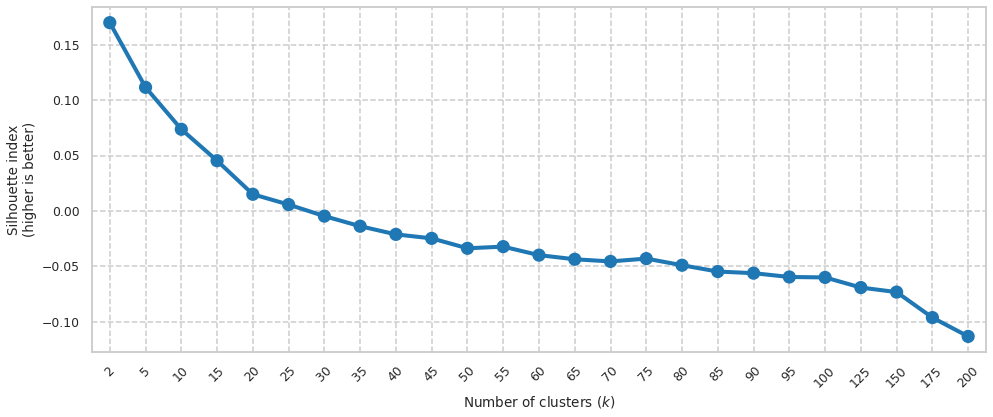

In [29]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))

    ax = sns.pointplot(data=ensemble, x="n_clusters", y="si_score")

    ax.set_ylabel("Silhouette index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()
    display(fig)
    plt.close(fig)